In [24]:
from pathlib import Path
from PIL import Image
import numpy as np
import cv2

In [25]:
root = Path.cwd()
for _ in range(6):
    if (root / '8_final_proj').exists():
        break
    if root.parent == root:
        break
    root = root.parent

team_candidates = [
    Path.cwd(),                              
    root / '8_final_proj' / 'Team YTK',      
]
TEAM = next((p for p in team_candidates if p.is_dir() and p.name == 'Team YTK'), None)
if TEAM is None:
    hits = [p for p in root.rglob('Team YTK') if p.is_dir()]
    TEAM = hits[0] if hits else None
if TEAM is None:
    raise FileNotFoundError(f"Can't find 'Team YTK' under {root}")

candidate_masks = [TEAM / 'VOC' / 'SegmentationClass', TEAM / 'SegmentationClass']
MASK_DIR = next((p for p in candidate_masks if p.is_dir()), None)
if MASK_DIR is None:
    raise FileNotFoundError(
        "No 'SegmentationClass' directory found. "
        f"Checked: {candidate_masks[0]} , {candidate_masks[1]} . "
    )

IMG_DIR = TEAM / 'VOC' / 'JPEGImages'

mask_path = str(MASK_DIR)
img_path = str(IMG_DIR)

print('Using Team dir  :', TEAM)
print('Using image dir :', IMG_DIR, ' (exists?', IMG_DIR.exists(), ')')
print('Using mask dir  :', MASK_DIR, ' (exists?', MASK_DIR.exists(), ')')
print('PNG masks       :', len(list(MASK_DIR.glob('*.png'))))
print('Images (jpg/png):', len(list(IMG_DIR.glob('*.jpg'))) + len(list(IMG_DIR.glob('*.png'))))

Using Team dir  : /Users/khantnyarkoko/Practical-ML-by-WAI/8_final_proj/Team YTK
Using image dir : /Users/khantnyarkoko/Practical-ML-by-WAI/8_final_proj/Team YTK/VOC/JPEGImages  (exists? True )
Using mask dir  : /Users/khantnyarkoko/Practical-ML-by-WAI/8_final_proj/Team YTK/VOC/SegmentationClass  (exists? True )
PNG masks       : 358
Images (jpg/png): 358


In [26]:
try:
    sm = next(MASK_DIR.glob('*.png'))
    mode = Image.open(sm).mode
    print('Sample mask:', sm.name, 'mode:', mode)
except StopIteration:
    print('Warning: no masks found to probe.')
    mode = None

Sample mask: cat.6.png mode: P


In [27]:
def load_mask_as_ids(path: Path) -> np.ndarray:
    im = Image.open(path)
    if im.mode == 'P':
        return np.array(im, dtype=np.int32)
    arr = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    if arr is None:
        arr = np.array(im.convert('RGB'))
    if arr.ndim == 2:
        arr = np.stack([arr]*3, axis=-1)
    elif arr.shape[-1] == 4:
        arr = cv2.cvtColor(arr, cv2.COLOR_BGRA2BGR)
    code = (arr[...,0].astype(np.uint32)
           + (arr[...,1].astype(np.uint32) << 8)
           + (arr[...,2].astype(np.uint32) << 16))
    uniques = np.unique(code)
    order = sorted(uniques, key=lambda x: (x != 0, x))  # (0,0,0) -> 0
    lut = {c:i for i,c in enumerate(order)}
    out = np.empty(code.shape, dtype=np.int32)
    out[:] = -1
    for c,i in lut.items():
        out[code == c] = i
    if (out < 0).any():
        raise RuntimeError('Some pixels did not map to any label.')
    return out

def build_pairs():
    imgs = {p.stem for p in IMG_DIR.glob('*.jpg')} | {p.stem for p in IMG_DIR.glob('*.png')}
    msks = {p.stem for p in MASK_DIR.glob('*.png')}
    paired = sorted(imgs & msks)
    print(f'images: {len(imgs)}  masks: {len(msks)}  paired: {len(paired)}')
    if len(paired) < min(len(imgs), len(msks)):
        extra_img = sorted(list(imgs - msks))[:5]
        extra_msk = sorted(list(msks - imgs))[:5]
        if extra_img: print('example images without mask:', extra_img)
        if extra_msk: print('example masks without image:', extra_msk)
    return paired

print('Setup complete.')

Setup complete.


In [28]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm 

In [29]:
def create_color_to_label_map(mask_folder_path):
    """
    Scans all masks in a folder to find unique colors and create a mapping
    from color to a class label.
    """
    print(f"Scanning masks in '{mask_folder_path}'...")
    
    unique_colors = set()
    

    mask_files = os.listdir(mask_folder_path)
    print(mask_files)
   
    for filename in tqdm(mask_files, desc="Finding unique colors"):
        mask_path = os.path.join(mask_folder_path, filename)

        mask_bgr = cv2.imread(mask_path)

        mask_rgb = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2RGB)
        # Reshape the (H, W, C) array to (H*W, C) to get a list of pixels
        pixels = mask_rgb.reshape(-1, 3)
        
        # Get unique rows (unique RGB colors)
        unique_pixel_colors = np.unique(pixels, axis=0)
        
        # Add the unique colors found in this image to our overall set
        for color in unique_pixel_colors:
            unique_colors.add(tuple(color))
            

    sorted_colors = sorted(list(unique_colors))
    
    # Create the color-to-label dictionary
    color_to_label = {color: label for label, color in enumerate(sorted_colors)}
    
    print("\nScan complete!")
    print(f"Found {len(color_to_label)} unique classes.")

    return color_to_label

In [30]:
mask_path = str(MASK_DIR)
COLOR_TO_LABEL = create_color_to_label_map(mask_path)
COLOR_TO_LABEL

Scanning masks in '/Users/khantnyarkoko/Practical-ML-by-WAI/8_final_proj/Team YTK/VOC/SegmentationClass'...
['cat.6.png', 'dog.946.png', 'dog.952.png', 'cat.946.png', 'cat.952.png', 'cat.24.png', 'cat.30.png', 'cat.18.png', 'dog.22.png', 'dog.36.png', 'cat.2136.png', 'cat.2320.png', 'cat.2334.png', 'cat.2335.png', 'cat.2321.png', 'dog.37.png', 'dog.23.png', 'cat.19.png', 'cat.31.png', 'cat.25.png', 'cat.953.png', 'cat.7.png', 'cat.2296.png', 'cat.5.png', 'cat.945.png', 'cat.979.png', 'cat.33.png', 'cat.27.png', 'dog.35.png', 'dog.21.png', 'cat.2323.png', 'cat.2322.png', 'dog.20.png', 'dog.34.png', 'cat.26.png', 'cat.32.png', 'cat.944.png', 'cat.950.png', 'dog.944.png', 'cat.2097.png', 'dog.950.png', 'cat.987.png', 'cat.4.png', 'dog.954.png', 'cat.0.png', 'dog.968.png', 'cat.983.png', 'cat.968.png', 'cat.954.png', 'cat.36.png', 'cat.22.png', 'dog.30.png', 'dog.24.png', 'dog.18.png', 'cat.2332.png', 'cat.2327.png', 'cat.2333.png', 'dog.19.png', 'dog.2329.png', 'dog.25.png', 'dog.31.png',

Finding unique colors: 100%|██████████| 358/358 [00:34<00:00, 10.42it/s]


Scan complete!
Found 3 unique classes.


{(np.uint8(0), np.uint8(0), np.uint8(0)): 0,
 (np.uint8(0), np.uint8(128), np.uint8(0)): 1,
 (np.uint8(128), np.uint8(0), np.uint8(0)): 2}

In [31]:
def encode_mask_to_grayscale(mask_path, color_map):
    """
    Converts an RGB segmentation mask to a grayscale mask with class labels.
    """
    mask_bgr = cv2.imread(mask_path)
    mask_rgb = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2RGB)
    height, width, _ = mask_rgb.shape
    
    mask_grayscale = np.zeros((height, width), dtype=np.uint8)

    for color, label in color_map.items():
        matches = np.where(np.all(mask_rgb == color, axis=-1))
        mask_grayscale[matches] = label
        
    return mask_grayscale
    

In [32]:
sample_mask_file = str(next(MASK_DIR.glob('*.png')))
grayscale_label_mask = encode_mask_to_grayscale(sample_mask_file, COLOR_TO_LABEL)

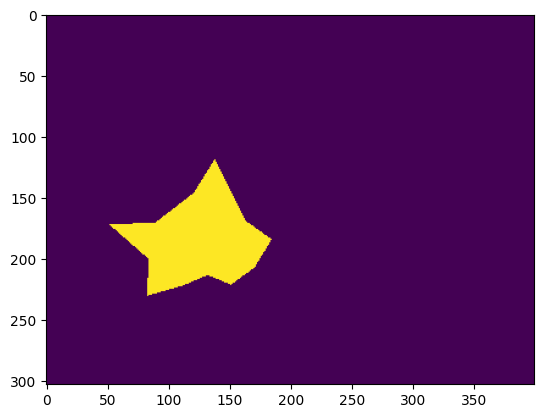

In [35]:
import matplotlib.pyplot as plt
save_path = "test_dataset/cats_and_dogs_filtered/train/cats/cat.6.jpg"

cv2.imwrite(save_path, grayscale_label_mask)
plt.imshow(grayscale_label_mask)

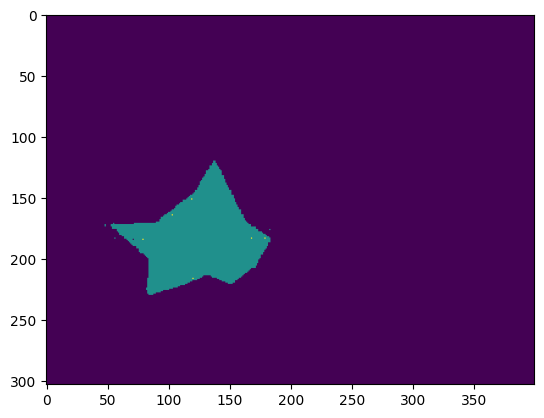

In [36]:
new_grayscale_label_mask = cv2.imread(save_path)
new_grayscale_label_mask = cv2.cvtColor(new_grayscale_label_mask, cv2.COLOR_BGR2GRAY)
plt.imshow(new_grayscale_label_mask)